In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, SpatialDropout2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util
import util_metrics

In [2]:
train_df = pd.read_csv("nih/train.csv")
valid_df = pd.read_csv("nih/validation.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.head()
train_df.tail()

,Image,Covid,Normal,Viral_Pneumonia
2118,Viral Pneumonia (970).png,0,0,1
2119,Viral Pneumonia (971).png,0,0,1
2120,Viral Pneumonia (972).png,0,0,1
2121,Viral Pneumonia (973).png,0,0,1
2122,Viral Pneumonia (974).png,0,0,1


In [3]:
labels = ['Covid', 
          'Normal', 
          'Viral_Pneumonia', 
          ]

In [4]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [5]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [6]:
IMAGE_DIR = "nih/images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 2123 validated image filenames.
getting train and valid generators...
Found 2123 validated image filenames.
Found 220 validated image filenames.
Found 562 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


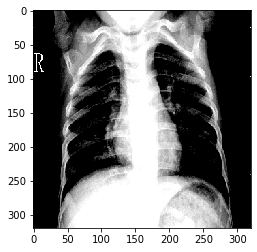

In [7]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

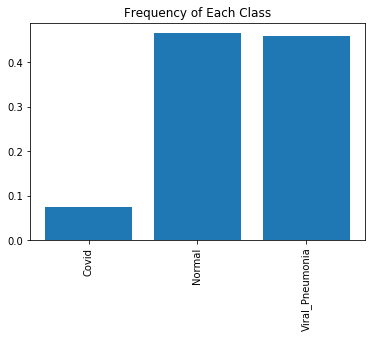

In [8]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [9]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels == 1,axis=0)/N
    negative_frequencies = np.sum(labels == 0,axis=0)/N

    return positive_frequencies, negative_frequencies

In [10]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.07489402, 0.46632124, 0.45878474])

Let's visualize these two contribution ratios next to each other for each of the pathologies:

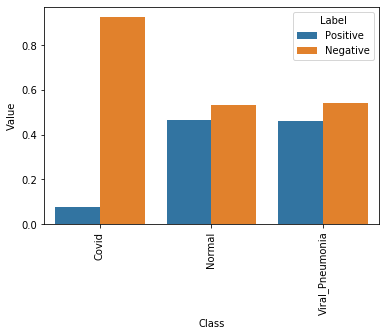

In [11]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [12]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

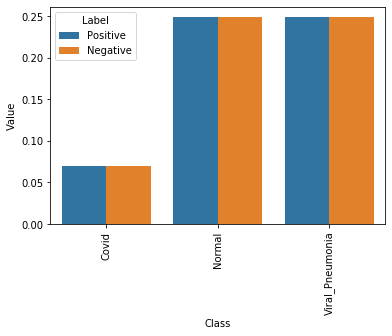

In [13]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [14]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            poss_loss = -1 * K.mean(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon))
            neg_loss = -1 * K.mean(neg_weights[i] * (1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon))
            loss += poss_loss + neg_loss  #complete this line
        return loss
    
    return weighted_loss

In [15]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(14, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [16]:
#model.summary()

In [17]:
model.load_weights("./nih/pretrained_model.h5")

In [18]:
model.layers.pop()
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [20]:
import tensorflow as tf
import keras
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)


In [21]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
  3/100 [..............................] - ETA: 8:44 - loss: 0.7633

KeyboardInterrupt: 

In [74]:
model.save('X-Ray_DenseNet.h5')

In [75]:
import pickle
with open('X-Ray_DenseNet trainHistoryDict.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [76]:
model.save_weights("X-Ray_DenseNet weights.h5")


## Prediction and Evaluation

Now that we have a model, let's evaluate it using our test set. We can conveniently use the `predict_generator` function to generate the predictions for the images in our test set.

In [77]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [78]:
predicted_vals.shape
y_test = test_df.copy()
y_test = y_test.drop('Image',axis=1)
test_results = y_test.copy()
for ind,label in enumerate(labels):
    test_results[label+'_pred'] = predicted_vals[:,ind]
    
y_test = y_test.values
test_results

,Covid,Normal,Viral_Pneumonia,Covid_pred,Normal_pred,Viral_Pneumonia_pred
0,1,0,0,0.986369,0.008924,0.143675
1,1,0,0,0.986369,0.008924,0.143675
2,1,0,0,0.998755,0.006807,0.020186
3,1,0,0,0.998755,0.006807,0.020186
4,1,0,0,0.998944,0.002033,0.012390
...,...,...,...,...,...,...
557,0,0,1,0.084349,0.096849,0.840167
558,0,0,1,0.000846,0.013230,0.988271
559,0,0,1,0.002571,0.009220,0.995855
560,0,0,1,0.055286,0.349234,0.724030


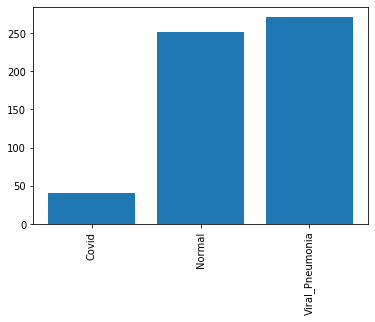

In [79]:
plt.xticks(rotation=90)
plt.bar(x = labels, height= y_test.sum(axis=0));

It seem like our dataset has an imbalanced population of samples.

###  ROC Curve and AUROC
AUC (Area Under the Curve) from the ROC (Receiver Operating Characteristic) curve. This is also referred to as the AUROC value, but all three terms in reference to the technique, and often used almost interchangeably.

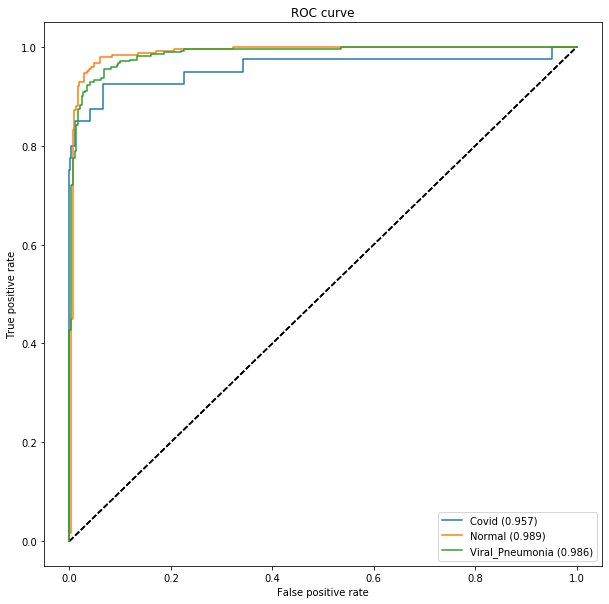

In [80]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

### Visualizing Learning with GradCAM 

In [81]:
df = pd.read_csv("nih/train.csv")
IMAGE_DIR = "nih/images/"

# only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Loading original image
Generating gradcam for class Covid
Generating gradcam for class Normal
Generating gradcam for class Viral_Pneumonia


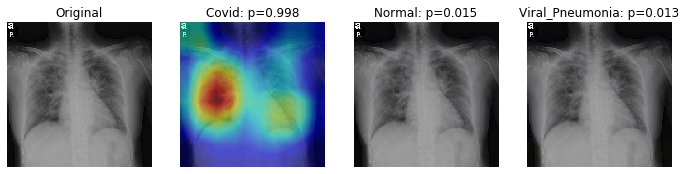

In [82]:
util.compute_gradcam(model, 'COVID-19(2).png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Covid
Generating gradcam for class Normal
Generating gradcam for class Viral_Pneumonia


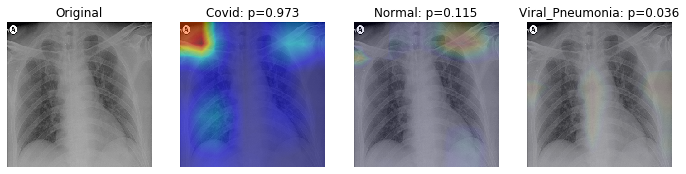

In [83]:
util.compute_gradcam(model, 'COVID-19(42).png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Covid
Generating gradcam for class Normal
Generating gradcam for class Viral_Pneumonia


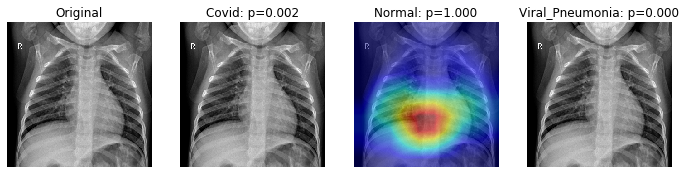

In [84]:
util.compute_gradcam(model, 'NORMAL (135).png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Covid
Generating gradcam for class Normal
Generating gradcam for class Viral_Pneumonia


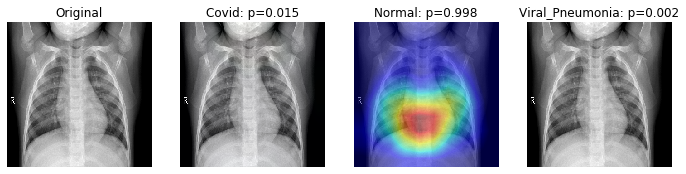

In [85]:
util.compute_gradcam(model, 'NORMAL (1000).png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Covid
Generating gradcam for class Normal
Generating gradcam for class Viral_Pneumonia


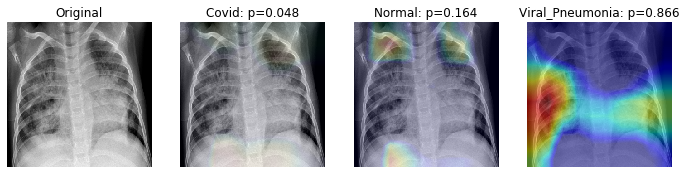

In [86]:
util.compute_gradcam(model, 'Viral Pneumonia (355).png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Covid
Generating gradcam for class Normal
Generating gradcam for class Viral_Pneumonia


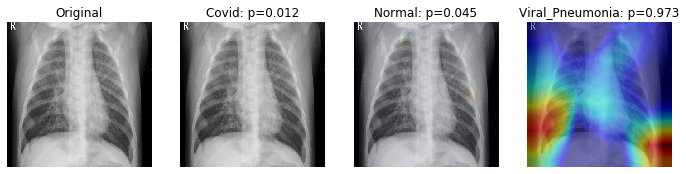

In [87]:
util.compute_gradcam(model, 'Viral Pneumonia (1342).png', IMAGE_DIR, df, labels, labels_to_show)

## Metrics

### True Positives, False Positives, True Negatives, and False Negatives

The most basic statistics to compute from the model predictions are the true positives, true negatives, false positives, and false negatives. 

As the name suggests
- true positive (TP): The model classifies the example as positive, and the actual label also positive.
- false positive (FP): The model classifies the example as positive, **but** the actual label is negative.
- true negative (TN): The model classifies the example as negative, and the actual label is also negative.
- false negative (FN): The model classifies the example as negative, **but** the label is actually positive.

We will count the number of TP, FP, TN and FN in the given data.  All of our metrics can be built off of these four statistics. 

Recall that the model outputs real numbers between 0 and 1.
* To compute binary class predictions, we need to convert these to either 0 or 1. 
* We'll do this using a threshold value $th$.
* Any model outputs above $th$ are set to 1, and below $th$ are set to 0. 

All of our metrics (except for AUC at the end) will depend on the choice of this threshold. 


In [88]:
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TN
    TN = np.sum((y==0) & (thresholded_preds==0))
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    # compute FP
    FP = np.sum((y==0) & (thresholded_preds==1))
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute FN
    FN = np.sum((y==1) & (thresholded_preds==0))
    
    return FN

In [89]:
util_metrics.get_performance_metrics(y_test, predicted_vals, labels)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Normal,247,284,27,4,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Viral_Pneumonia,244,284,7,27,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


### Accuracy


Let's use a threshold of .5 for the probability cutoff for our predictions for all classes and calculate our model's accuracy as we would normally do in a machine learning problem. 

$$accuracy = \frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{true negatives} + \text{false positives} + \text{false negatives}}$$


In [90]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return accuracy

In [91]:
util_metrics.get_performance_metrics(y_test, predicted_vals, labels, acc=get_accuracy)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,0.968,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Normal,247,284,27,4,0.945,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Viral_Pneumonia,244,284,7,27,0.94,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


### Prevalence
Another important concept is **prevalence**. 
* In a medical context, prevalence is the proportion of people in the population who have the disease (or condition, etc). 
* In machine learning terms, this is the proportion of positive examples. The expression for prevalence is:

$$prevalence = \frac{1}{N} \sum_{i} y_i$$

where $y_i = 1$ when the example is 'positive' (has the disease).

In [92]:
def get_prevalence(y):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    prevalence = np.mean(y)
    
    return prevalence

In [93]:
util_metrics.get_performance_metrics(y_test, predicted_vals, labels, acc=get_accuracy, prevalence=get_prevalence)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,0.968,0.071,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Normal,247,284,27,4,0.945,0.447,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Viral_Pneumonia,244,284,7,27,0.94,0.482,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


### Sensitivity and Specificity
<img src="sens_spec.png" width="30%">

Sensitivity and specificity are two of the most prominent numbers that are used to measure diagnostics tests.
- Sensitivity is the probability that our test outputs positive given that the case is actually positive.
- Specificity is the probability that the test outputs negative given that the case is actually negative. 

We can phrase this easily in terms of true positives, true negatives, false positives, and false negatives: 

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$specificity = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$


In [94]:
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y,pred,th)
    FP = false_positives(y,pred,th)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    
    return specificity

In [95]:
util_metrics.get_performance_metrics(y_test, predicted_vals, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,0.968,0.071,0.85,0.977,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Normal,247,284,27,4,0.945,0.447,0.984,0.913,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Viral_Pneumonia,244,284,7,27,0.94,0.482,0.9,0.976,Not Defined,Not Defined,Not Defined,Not Defined,0.5


Note that specificity and sensitivity do not depend on the prevalence of the positive class in the dataset. 
* This is because the statistics are only computed within people of the same class
* Sensitivity only considers output on people in the positive class
* Similarly, specificity only considers output on people in the negative class.

### PPV and NPV

Diagnostically, however, sensitivity and specificity are not helpful. Sensitivity, for example, tells us the probability our test outputs positive given that the person already has the condition. Here, we are conditioning on the thing we would like to find out (whether the patient has the condition)!

What would be more helpful is the probability that the person has the disease given that our test outputs positive. That brings us to positive predictive value (PPV) and negative predictive value (NPV).

- Positive predictive value (PPV) is the probability that subjects with a positive screening test truly have the disease.
- Negative predictive value (NPV) is the probability that subjects with a negative screening test truly don't have the disease.

Again, we can formulate these in terms of true positives, true negatives, false positives, and false negatives: 

$$PPV = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$ 

$$NPV = \frac{\text{true negatives}}{\text{true negatives} + \text{false negatives}}$$


In [96]:
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)

    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    
    return NPV

In [97]:
util_metrics.get_performance_metrics(y_test, predicted_vals, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,0.968,0.071,0.85,0.977,0.739,0.988,Not Defined,Not Defined,0.5
Normal,247,284,27,4,0.945,0.447,0.984,0.913,0.901,0.986,Not Defined,Not Defined,0.5
Viral_Pneumonia,244,284,7,27,0.94,0.482,0.9,0.976,0.972,0.913,Not Defined,Not Defined,0.5


### ROC Curve

So far we have been operating under the assumption that our model's prediction of `0.5` and above should be treated as positive and otherwise it should be treated as negative. This however was a rather arbitrary choice. One way to see this, is to look at a very informative visualization called the receiver operating characteristic (ROC) curve.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ideal point is at the top left, with a true positive rate of 1 and a false positive rate of 0. The various points on the curve are generated by gradually changing the threshold.


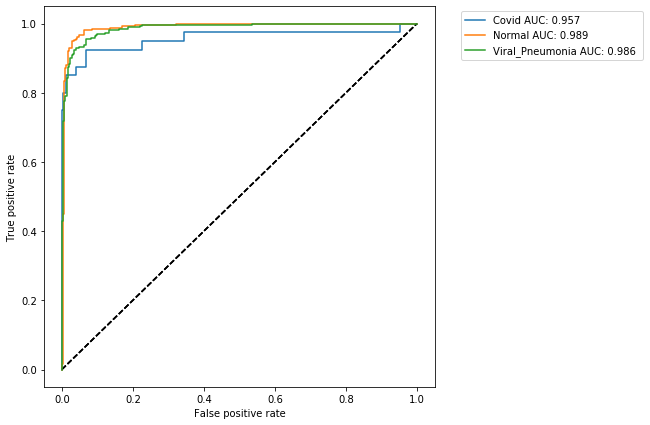

In [98]:
util_metrics.get_curve(y_test, predicted_vals, labels)

The area under the ROC curve is also called AUCROC or C-statistic and is a measure of goodness of fit. In medical literature this number also gives the probability that a randomly selected patient who experienced a condition had a higher risk score than a patient who had not experienced the event. This summarizes the model output across all thresholds, and provides a good sense of the discriminative power of a given model.


In [99]:
from sklearn.metrics import roc_auc_score
util_metrics.get_performance_metrics(y_test, predicted_vals, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,0.968,0.071,0.85,0.977,0.739,0.988,0.957,Not Defined,0.5
Normal,247,284,27,4,0.945,0.447,0.984,0.913,0.901,0.986,0.989,Not Defined,0.5
Viral_Pneumonia,244,284,7,27,0.94,0.482,0.9,0.976,0.972,0.913,0.986,Not Defined,0.5


## Confidence Intervals

It would be good to quantify this uncertainty due to the sampling of our dataset. We'll do this through the use of confidence intervals. A 95\% confidence interval for an estimate $\hat{s}$ of a parameter $s$ is an interval $I = (a, b)$ such that 95\% of the time when the experiment is run, the true value $s$ is contained in $I$. More concretely, if we were to run the experiment many times, then the fraction of those experiments for which $I$ contains the true parameter would tend towards 95\%.

While some estimates come with methods for computing the confidence interval analytically, more complicated statistics, such as the AUC for example, are difficult. For these we can use a method called the *bootstrap*. The bootstrap estimates the uncertainty by resampling the dataset with replacement. For each resampling $i$, we will get a new estimate, $\hat{s}_i$. We can then estimate the distribution of $\hat{s}$ by using the distribution of $\hat{s}_i$ for our bootstrap samples.

In the code below, we create bootstrap samples and compute sample AUCs from those samples. Note that we use stratified random sampling (sampling from the positive and negative classes separately) to make sure that members of each class are represented. 

In [100]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y_test, predicted_vals, labels)

In [101]:
util_metrics.print_confidence_intervals(labels, statistics)

,Mean AUC (CI 5%-95%)
Covid,0.96 (0.93-0.99)
Normal,0.99 (0.98-0.99)
Viral_Pneumonia,0.99 (0.98-0.99)


## Precision-Recall Curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 

In information retrieval
- Precision is a measure of result relevancy and that is equivalent to our previously defined PPV. 
- Recall is a measure of how many truly relevant results are returned and that is equivalent to our previously defined sensitivity measure.

The precision-recall curve (PRC) shows the trade-off between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. 

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Run the following cell to generate a PRC:

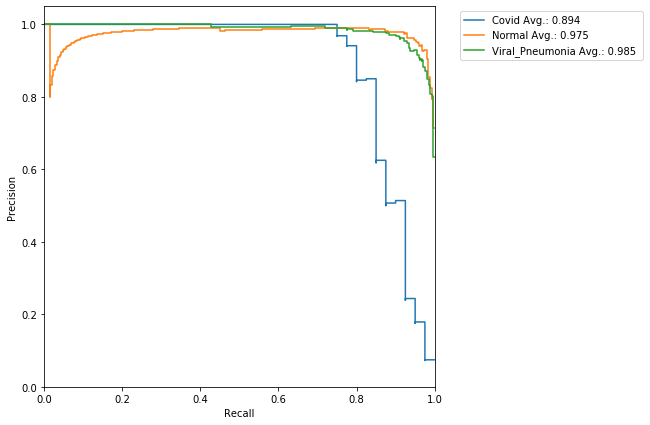

In [102]:
util_metrics.get_curve(y_test, predicted_vals, labels, curve='prc')

## F1 Score

F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. 


In [103]:
from sklearn.metrics import f1_score
util_metrics.get_performance_metrics(y_test, predicted_vals, labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,34,510,12,6,0.968,0.071,0.85,0.977,0.739,0.988,0.957,0.791,0.5
Normal,247,284,27,4,0.945,0.447,0.984,0.913,0.901,0.986,0.989,0.941,0.5
Viral_Pneumonia,244,284,7,27,0.94,0.482,0.9,0.976,0.972,0.913,0.986,0.935,0.5


## Calibration

When performing classification we often want not only to predict the class label, but also obtain a probability of each label. This probability would ideally give us some kind of confidence on the prediction. In order to observe how our model's generated probabilities are aligned with the real probabilities, we can plot what's called a *calibration curve*. 

In order to generate a calibration plot, we first bucketize our predictions to a fixed number of separate bins (e.g. 5) between 0 and 1. We then calculate a point for each bin: the x-value for each point is the mean for the probability that our model has assigned to these points and the y-value for each point fraction of true positives in that bin. We then plot these points in a linear plot. A well-calibrated model has a calibration curve that almost aligns with the y=x line.

The `sklearn` library has a utility `calibration_curve` for generating a calibration plot.

In [104]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(labels[i])
    plt.tight_layout()
    plt.show()

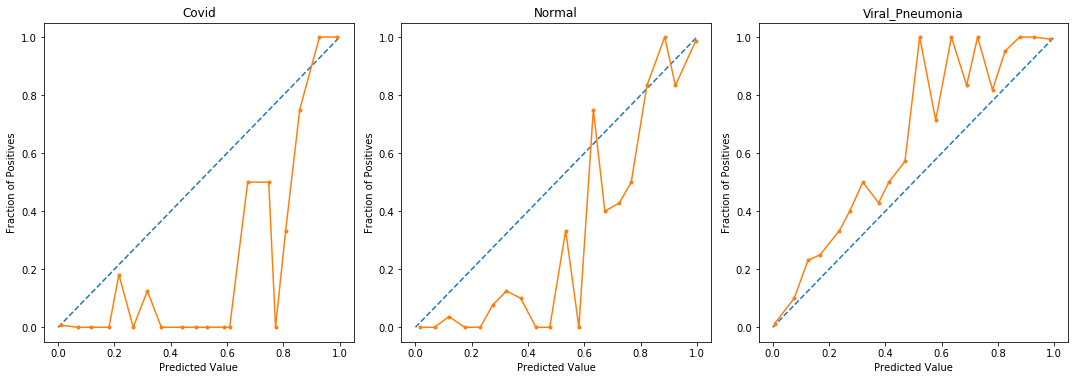

In [105]:
plot_calibration_curve(y_test, predicted_vals)